In [1]:
!pip install igraph
!pip install scikit-image==0.20.0

In [3]:
import sys
sys.path.append('../GNEMS')
from GNEMS import GraphicallyGuidedEMSegmentor, GNEMS_segment
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import skimage.util
from PIL import Image
import tqdm
import os
from evaluate import calculate_mIOU
import json
import pandas as pd
import cv2

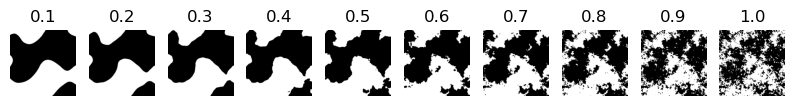

In [2]:
image_paths = sorted(list(glob("../datasets/edge_complexity/gt/perlin_*_003.png")))
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i, path in enumerate(image_paths):
    axs[i].imshow(plt.imread(path))
    axs[i].axis('off')
    axs[i].set_title(path.split('_')[-2])

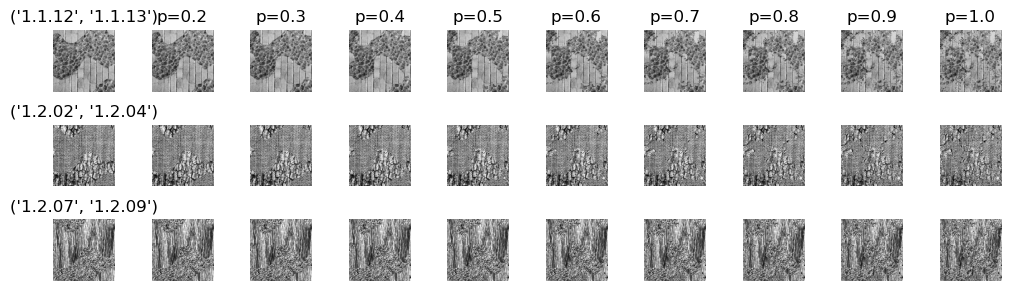

In [14]:
images = np.array([plt.imread(path)[:,:,0] for path in image_paths])
def preprocess_texture(texture):
    desired_crop = (10, 10, 10, 10)
    # center crop image
    texture = texture[desired_crop[0]:-desired_crop[1], desired_crop[2]:-desired_crop[3]]
    im = Image.fromarray(texture).convert("L")
    im = im.resize((512, 512), resample=Image.BILINEAR)
    return np.array(im)

texture_pairs = [("1.1.12","1.1.13"),("1.2.02","1.2.04"),("1.2.07","1.2.09")]
complexities = [float(path.split('_')[-2]) for path in image_paths]
blended_images = np.zeros((len(images), len(texture_pairs), 512, 512))
for im_num, gt in enumerate(images):
    for pair_num, texture_pair in enumerate(texture_pairs):
        texture1 = plt.imread(f"../raw_textures/{texture_pair[0]}.tiff")
        texture2 = plt.imread(f"../raw_textures/{texture_pair[1]}.tiff")
        texture1 = preprocess_texture(texture1)
        texture2 = preprocess_texture(texture2)
        mask = cv2.GaussianBlur(gt.astype(float), (5, 5), 0)
        blended = (texture1 * mask) + (texture2 * (1-mask))
        blended = Image.fromarray(blended).convert("L")
        blended_images[im_num, pair_num, :, :] = np.array(blended)

fig, axs = plt.subplots(3, 10, figsize=(10, 3))
for i in range(blended_images.shape[0]):
    for k in range(blended_images.shape[1]):
        axs[k,i].imshow(blended_images[i,k], cmap='gray')
        axs[k,i].axis('off')
        if i == 0:
            axs[k, i].set_title(f"{str(texture_pairs[k])}")
        if k == 0 and i != 0:
            axs[k, i].set_title(f"p={complexities[i]}")
plt.tight_layout()

In [21]:
import concurrent.futures

def segment_and_save(paramset):
    d = paramset["d"]
    p = paramset["p"]
    pair_index = paramset["pair_index"]
    seed = paramset["seed"]
    bar = paramset["bar"]
    lambda_ = paramset["lambda_"]
    if os.path.exists(f"lambda_effects_textures_output/lambda_{lambda_:.1f}_pair_{pair_index:.1f}_p_{p:.1f}_seed_{seed:02d}.png"):
        bar.update(1)
        return
    im = blended_images[paramset["p_index"], paramset["pair_index"]]
    seg = GNEMS_segment(im, d=d, lambda_=lambda_,
            iterations=50, prediction_stride=8,
            slic_segments=100, sigma=3, show_progress=False, seed=seed)
    seg = Image.fromarray((seg * 255).astype(np.uint8)).convert('L')
    seg.save(f"lambda_effects_textures_output/lambda_{lambda_:.1f}_pair_{pair_index:.1f}_p_{p:.1f}_seed_{seed:02d}.png")
    bar.update(1)

lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
pair_indices = [0, 1, 2]
complexities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
seeds = list(range(100))
paramsets = []
with tqdm.tqdm(total=len(lambda_values) * len(pair_indices) * len(complexities) * len(seeds)) as pbar:
    for p_index, p in enumerate(complexities):
        for pair_index in pair_indices:
            for lambda_ in lambda_values:
                for seed in seeds:
                    paramsets.append({"bar":pbar, "d":16, "pair_index":pair_index, "p":p, "p_index":p_index, "lambda_":lambda_, "seed":seed})

    with concurrent.futures.ThreadPoolExecutor(max_workers=60) as executor:
        res = executor.map(segment_and_save, paramsets)
    for result in res:
        pass
            

100%|██████████| 180/180 [11:46<00:00,  3.92s/it]


In [22]:
segmentation_paths = sorted(list(glob("lambda_effects_textures_output/*.png")))
lambdas = []
pair_indices = []
ps = []
mious = []
for path in tqdm.tqdm(segmentation_paths):
    split_name = ".".join(path.split('/')[-1].split(".")[:-1]).split("_")
    lambda_ = float(split_name[1])
    pair_index = float(split_name[3])
    p = float(split_name[5])
    gt_path = f"../datasets/edge_complexity/gt/perlin_{p:.1f}_003.png"
    gt = plt.imread(gt_path)[:,:,0]
    seg = plt.imread(path)
    miou = calculate_mIOU(seg, gt)
    lambdas.append(lambda_)
    pair_indices.append(pair_index)
    ps.append(p)
    mious.append(miou)

results = np.array([lambdas, pair_indices, ps, mious]).T

with open("lambda_effects_textures_results.json", "w") as f:
    json.dump(results.tolist(), f)

100%|██████████| 180/180 [00:08<00:00, 21.49it/s]


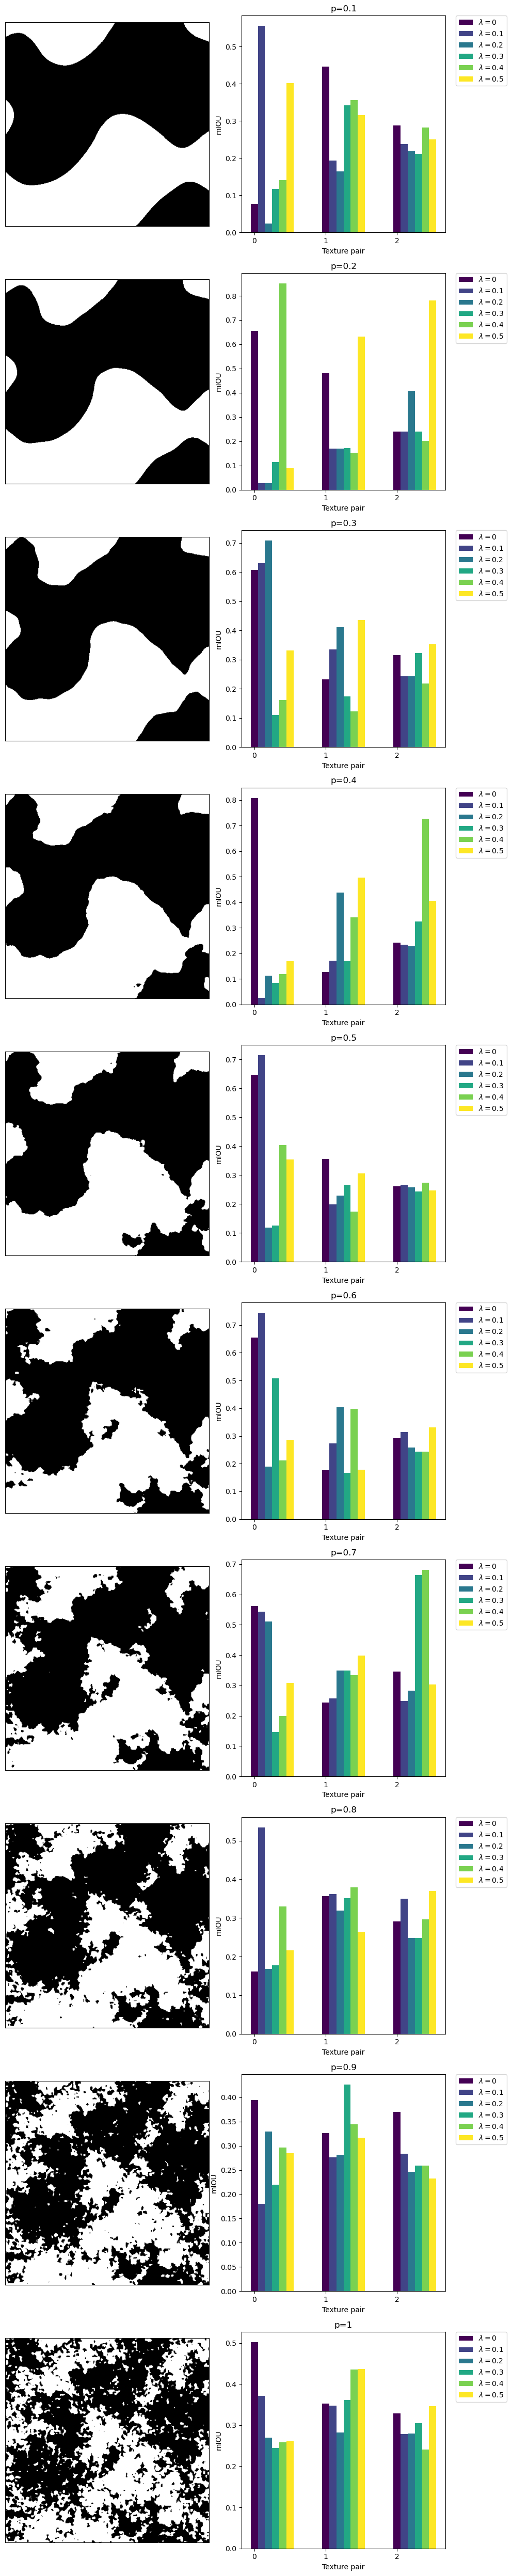

In [27]:
with open("lambda_effects_textures_results.json", "r") as f:
    results = np.array(json.load(f))

df = pd.DataFrame(results, columns=["lambda_", "pair_index", "p", "mIOU"])
lambda_subset = lambda_values[:6]
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_subset)))
fig, axs = plt.subplots(10, 2, figsize=(10, 50))
for i, p in enumerate(complexities):
    df_p = df[df["p"] == p]
    for j, lambda_ in enumerate(lambda_subset):
        df_lambda = df_p[df_p["lambda_"] == lambda_]
        axs[i,1].bar(df_lambda["pair_index"] + j*0.1, df_lambda["mIOU"], width=0.1, color=colors[j], label=f"$\lambda={lambda_}$")
    axs[i,1].set_xticks([0, 1, 2])
    axs[i,1].set_xticklabels(["0", "1", "2"])
    axs[i,1].set_title(f"p={p}")
    axs[i,1].set_xlabel(r"Texture pair")
    axs[i,1].set_ylabel("mIOU")
    axs[i,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[i,0].imshow(plt.imread(f"../datasets/edge_complexity/gt/perlin_{p:.1f}_003.png")[:,:,0], cmap='gray')
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
plt.tight_layout()

In [ ]:
# Use seed to change perlin noise too